# Neutron star structure

We'll investigate neutron star structure by consider both the standard hydrostatic equilibrium:

$$\frac{dP}{dr} = - \frac{G M(r)}{r^2}$$

and the general relativistic [Tolman-Oppenheimer-Volkoff equation](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation):

$$\frac{dP}{dr} = -\frac{G}{r^2} \left (\rho + \frac{P}{c^2}\right )
    \left ( M(r) + \frac{4\pi r^3 P}{c^2} \right ) \left (1 - \frac{2 GM(r)}{rc^2} \right )^{-1}$$
    
In both cases, $M(r)$ satisties:

$$\frac{dM}{dr} = 4\pi r^2 \rho$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here's a general integration class that implemented 4th order Runge-Kutta.  It takes
a `rhs` function of the form:

```
rhs(r, Y, rho_func)
```

that returns the derivatives $d{\bf Y}/dr$ for each of the variables in the array ${\bf Y}$.
Here, `rho_func` is a function `rho_func(pres)` that takes the pressure and returns the
density according to our EOS.

It can also take a list of stopping criteria for each variable, so we end the integration
when we reach the edge of the star.  The integration step is fixed, until we hit the stopping
criteria.  Then it cuts dx by factors of 2 until we meet our tolerance at the stopping point.

In [2]:
class Integrator:
    """ this is a simple RK4 integrator with a uniform step size
    that can accept a list of stopping criteria to halt the integration.

    There is one list element for each variable.  An entry of "None"
    means that we have no stopping criteria for that variable.  A tuple
    of the form ("LT", val) or ("GT", val), means that we stop if
    y[n] < val (or y[n] > val)
    """

    def __init__(self, rhs, *, stop_cond=None, rhs_args=None):
        self.rhs = rhs
        self.stop_cond = stop_cond
        if rhs_args is None:
            rhs_args = []
        self.args = rhs_args

    def rk4_step(self, x, y, dx):

        dydx1 = self.rhs(x, y, *self.args)
        y1 = y + 0.5*dx*dydx1
        if self.check_stop_cond(y1) < 0: return None

        dydx2 = self.rhs(x + 0.5*dx, y1, *self.args)
        y2 = y + 0.5*dx*dydx2
        if self.check_stop_cond(y2) < 0: return None

        dydx3 = self.rhs(x + 0.5*dx, y2, *self.args)
        y3 = y + dx*dydx3
        if self.check_stop_cond(y3) < 0: return None

        dydx4 = self.rhs(x + dx, y3, *self.args)

        y_final = y + (dx/6.0)*(dydx1 + 2.0*dydx2 + 2.0*dydx3 + dydx4)
        if self.check_stop_cond(y_final) < 0: return None

        return y_final

    def check_stop_cond(self, y):
        # check our stopping conditions
        if not self.stop_cond is None:
            for n, cond in enumerate(self.stop_cond):
                if cond is None: continue
                c, v = cond
                if c == "LT":
                    if y[n] < v: return -1
                elif c == "GT":
                    if ynew[n] > v: return -1
                else:
                    sys.exit("invalid condition")

        return 0

    def integrate(self, initial_conditions, dx, xmax, tol=1.e-8):
        ic = np.array(initial_conditions)
        N = len(ic)
        sol = {}
        for n in range(N):
            sol[f"y{n}"] = [ic[n]]

        x = 0.0
        sol["x"] = [x]

        y = initial_conditions
        
        while (x < xmax and dx > tol * xmax):
            # advance for a step
            ynew = self.rk4_step(x, y, dx)

            if ynew is None:
                # we hit our stopping condition
                # cut the stepsize so we can try to get closer
                dx /= 2
                continue

            # store the solution
            x += dx
            sol["x"].append(x)
            for n in range(N):
                sol[f"y{n}"].append(ynew[n])

            y = ynew

        return sol

For the both HSE and TOV, we integrate

$${\bf Y} = \left ( \begin{array}{c} m \\ P \end{array} \right )$$

All of our units will be in CGS.

Some physical constants (CGS)

In [3]:
G = 6.67e-8
c = 3.e10
h = 6.63e-27
m_u = 1.66e-24

Here's the righthand side function for the TOV equation

In [4]:
def rhs_tov(r, y, rho_func):
    m = y[0]
    P = y[1]

    rho = rho_func(P)
    
    dmdr = 4.0 * np.pi * r**2 * rho
        
    if r == 0.0:
        dPdr = 0.0
    else:
        rho_term = rho + P / c**2
        m_term = m + 4.0 * np.pi * r**3 * P / c**2
        metric_term = (1.0 - 2.0 * G * m / (r * c**2))
        dPdr = -(G / r**2) * rho_term * m_term / metric_term

    return np.array([dmdr, dPdr])

Here's the righthand side function for Newtonian HSE

In [5]:
def rhs_newton(r, y, rho_func):
    m = y[0]
    P = y[1]

    rho = rho_func(P)
    
    dmdr = 4.0 * np.pi * r**2 * rho
    
    if r == 0.0:
        dPdr = 0.0
    else:
        dPdr = -G * m / r**2 * rho
        
    return np.array([dmdr, dPdr])

## Degenerate neutrons

For zero-T neutron degeneracy, the number density of neutrons is just the integral of the distribution function, $n(p)$, over all momenta:

$$n = \int n(p) d^3 p = 4\pi \int_0^\infty n(p) p^2 dp$$

but at zero temperature the distribution function is just a step function:

$$n(p) = \frac{2}{h^3}\left \{ \begin{array}{cc} 1 & \mbox{if } p < p_F \\
                                    0 & \mbox{otherwise} \end{array}\right .$$
                                    
This gives:

$$n = \frac{\rho}{m_u} = \frac{8\pi}{3h^3} p_F^3 = \frac{8\pi}{3} \left (\frac{m_u c}{h} \right )^3 x_F^3$$

where $x_F = p_F / (m_u c)$.

We can then compute the pressure as:

$$P = \frac{1}{3} \int n(p) v p d^3 p$$

where we now need to use the general expression for velocity, 

$$v = \frac{p}{m_u} \left [ 1 + \left ( \frac{p}{m_u c} \right)^2 \right ]^{-1/2}$$

This gives:

$$P = \frac{\pi}{3} \left ( \frac{m_u c}{h} \right )^3 m_u c^2 f(x)$$

with

$$f(x) = x (2x^2 - 3) (1 + x^2)^{1/2} + 3 \sinh^{-1}(x)$$

In [6]:
from scipy.optimize import brentq

def pres_deg(rho):
    # compute the Fermi momentum x = p / mc
    B = 8 * np.pi * m_u / 3.0 * (m_u * c / h)**3
    x = np.cbrt(rho / B)
    
    f = x * (2 * x**2 - 3) * np.sqrt(1 + x**2) + 3 * np.arcsinh(x)
    A = (np.pi / 3) * (m_u * c / h)**3 * m_u * c**2
    
    return A * f
    
def rho_deg(pres):
    
    A = (np.pi / 3) * (m_u * c / h)**3 * m_u * c**2
    f = pres / A
    
    # find the x that gives us this f
    x = brentq(lambda x: f - (x * (2 * x**2 - 3) * np.sqrt(1 + x**2) + 3 * np.arcsinh(x)), 0, 10)
    
    B = 8 * np.pi * m_u / 3.0 * (m_u * c / h)**3
    return B * x**3 

## A polytropic nuclear EOS

A simple polytopic approximation to a nuclear equation of state (the SLy4 EOS) is:


$$P = K \left ( \frac{\rho}{\rho_0} \right )^\gamma$$

If we choose $K = 3.5 \mathrm{MeV~fm^{-3}}$ and $\rho_0 = 150 \mathrm{MeV~fm^{-3}}$, we approximate the behavior of the SLy4 nuclear EOS (thanks to Tianqi Zhao for these approximations) with $\gamma = 2.5$.

In CGS units, using $\gamma = 2.5$, we can take $K = 4.80\times 10^{-3}~\mathrm{erg~cm^{-3}}$ and write this as:

$$P = K \rho^\gamma$$


In [7]:
def pres_nuc(rho):
    gamma = 2.5
    K = 4.8e-3
    
    return K * rho**gamma

def rho_nuc(pres):
    gamma = 2.5
    K = 4.8e-3
    
    return (pres / K)**(1.0 / gamma)

## Case I: Newtonian gravity, neutron degeneracy

We'll loop over the central density and integrate the neutron star structure and store the mass and radius corresponding to each central density.

In [8]:
ns1 = Integrator(rhs_newton, rhs_args=[rho_deg],
                 stop_cond=[("LT", 0.0), ("LT", 0.0)])

R_max = 5.e6
N = 1000

mass = []
radius = []

for rhoc in np.logspace(np.log10(5.e14), np.log10(5.e16), 100):
    
    Pc = pres_deg(rhoc)
    
    sol = ns1.integrate([0.0, Pc], R_max/N, R_max)
    
    mass.append(sol["y0"][-1]/2.e33)
    radius.append(sol["x"][-1]/1.e5)

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1247426/1020375860.py:5: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel("$M$ [$M_\odot$]")


Text(0, 0.5, '$M$ [$M_\\odot$]')

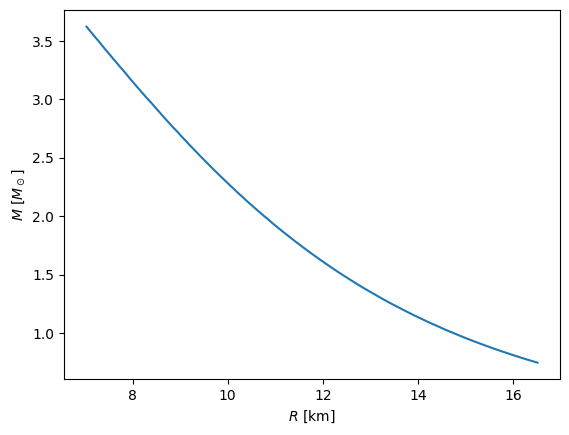

In [9]:
fig, ax = plt.subplots()

ax.plot(radius, mass)
ax.set_xlabel("$R$ [km]")
ax.set_ylabel("$M$ [$M_\odot$]")

Here we see a curve reminiscient of the white dwarf mass-radius relation.  This is not physical since we've neglected GR and the nuclear interactions.

What happens if we take $\rho \rightarrow \infty$?  We should get the neutron star version of the
Chandrasekhar mass:

$$M_\mathrm{Ch} = 1.44 \left ( \frac{2}{\mu} \right )^2 M_\odot$$

For electrons, the $\mu$ was $\mu_e$, but now it is just $\mu = 1$ for neutrons, giving a mass of
$M_\mathrm{Ch} \sim 5.76~ M_\odot$

Text(0, 0.5, '$M$ [$M_\\odot$]')

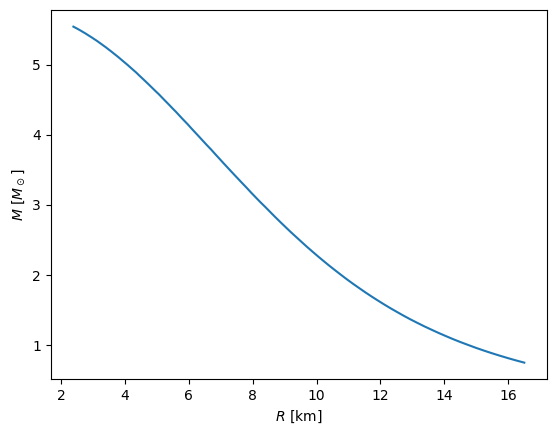

In [10]:
ns1 = Integrator(rhs_newton, rhs_args=[rho_deg],
                 stop_cond=[("LT", 0.0), ("LT", 0.0)])

R_max = 5.e6
N = 1000

mass = []
radius = []

for rhoc in np.logspace(np.log10(5.e14), np.log10(5.e18), 100):
    
    Pc = pres_deg(rhoc)
    
    sol = ns1.integrate([0.0, Pc], R_max/N, R_max)
    
    mass.append(sol["y0"][-1]/2.e33)
    radius.append(sol["x"][-1]/1.e5)
    
fig, ax = plt.subplots()

ax.plot(radius, mass)
ax.set_xlabel("$R$ [km]")
ax.set_ylabel(r"$M$ [$M_\odot$]")

We see that we are approaching that maximum mas as $R \rightarrow 0$, as expected.

## Case II: GR gravity + degenerate EOS

In [11]:
ns2 = Integrator(rhs_tov, rhs_args=[rho_deg],
                 stop_cond=[("LT", 0.0), ("LT", 0.0)])

R_max = 5.e6
N = 1000

# my vector is [m, p]
mass = []
radius = []
for rhoc in np.logspace(np.log10(5.e14), np.log10(5.e16), 100):

    Pc = pres_deg(rhoc)

    sol = ns2.integrate([0.0, Pc], R_max/N, R_max)

    mass.append(sol["y0"][-1]/2.e33)
    radius.append(sol["x"][-1]/1.e5)

Text(0, 0.5, '$M$ [$M_\\odot$]')

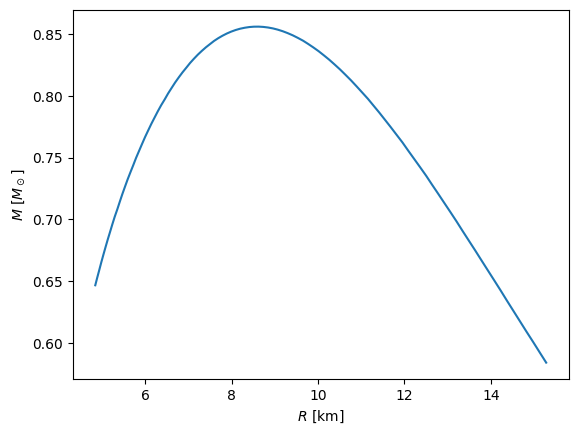

In [12]:
fig, ax = plt.subplots()

ax.plot(radius, mass)
ax.set_xlabel("$R$ [km]")
ax.set_ylabel(r"$M$ [$M_\odot$]")

Now, adding GR, we see that there is a maximum mass for the neutron star, but it is quite low.

## Case III: GR gravity + nuclear EOS


In [13]:
ns3 = Integrator(rhs_tov, rhs_args=[rho_nuc],
                 stop_cond=[("LT", 0.0), ("LT", 0.0)])

R_max = 5.e6
N = 1000

# my vector is [m, p]
mass = []
radius = []
for rhoc in np.logspace(np.log10(5.e14), np.log10(5.e16), 100):

    Pc = pres_nuc(rhoc)

    sol = ns3.integrate([0.0, Pc], R_max/N, R_max)

    mass.append(sol["y0"][-1]/2.e33)
    radius.append(sol["x"][-1]/1.e5)

Text(0, 0.5, '$M$ [$M_\\odot$]')

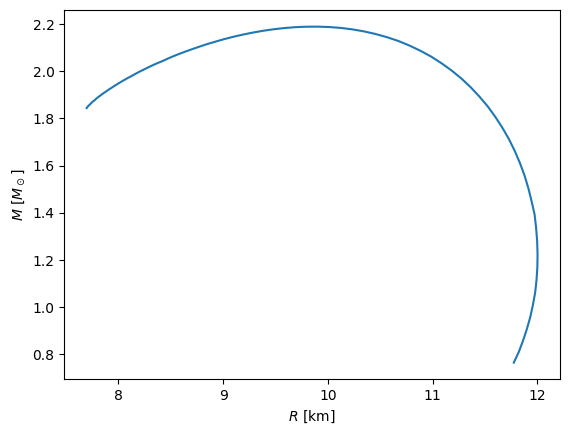

In [14]:
fig, ax = plt.subplots()

ax.plot(radius, mass)
ax.set_xlabel("$R$ [km]")
ax.set_ylabel(r"$M$ [$M_\odot$]")

In this final case, we get a much more reasonable maximum neutron star mass.  We also see that
for some values of radius there are multiple masses (the M-R relation is double-valued) -- this is okay.
However, at the very highest central densities, we get a smaller mass than the maximum at a smaller radius -- that is not physical, and is dynamically unstable.

## Case IV: Blended EOS

Let's now try an EOS that is stiff at the center but transitions to the non-relativisitic neutron degeneracy EOS at lower densities.

We'll write this as:

$$P = \left \{ \begin{array}{cc} K_0 \rho^{\gamma_0} & \mbox{if } \rho < \rho_{tr} \\
                                 K_1 \rho^{\gamma_1} & \mbox{otherwise} \end{array} \right .$$

We'll take $K_0$, $\gamma_0$ to be the non-relativitic neutron degeneracy parameters, $\gamma_0 = 5/3$
and

$$K_0 = \frac{h^2}{20} \left ( \frac{3}{\pi} \right )^{2/3} \frac{1}{m_u^{8/3}}$$

For the transition density, we will take $x_F = 1/2$, which gives

$$\frac{\rho}{m_u} = \frac{8\pi}{3} \left (\frac{m_u c}{h} \right )^3 x_F^3$$

We'll take $\gamma_1 = 2.5$ as above

Let's evaluate these

In [15]:
gamma_0 = 5./3.
gamma_1 = 10

In [16]:
rho_tr = m_u * (8 * np.pi / 3) * (m_u * c / h)**3 * (1/2)**3
rho_tr

736688938797371.4

In [17]:
K0 = h**2/20 * (3/np.pi)**(2/3) / m_u**(8/3)
K0

5516831857.874235

In [18]:
K1 = K0 * rho_tr**(gamma_0 - gamma_1)
K1

7.041337677911962e-115

That gives a transition density of $\sim 7\times 10^{14}~\mathrm{g~cm^{-3}}$

In [19]:
def pres_blend(rho):
    if rho < rho_tr:
        return K0 * rho**gamma_0
    return K1 * rho**gamma_1

def rho_blend(pres):
    P_tr = K0 * rho_tr**gamma_0
    
    if pres < P_tr:
        return (pres / K0)**(1/gamma_0)
    return (pres / K1)**(1/gamma_1)

In [20]:
ns4 = Integrator(rhs_tov, rhs_args=[rho_blend],
                 stop_cond=[("LT", 0.0), ("LT", 0.0)])

R_max = 5.e6
N = 250

# my vector is [m, p]
mass = []
radius = []
for rhoc in np.logspace(np.log10(1.e14), np.log10(2.e16), 100):
    Pc = pres_blend(rhoc)

    sol = ns4.integrate([0.0, Pc], R_max/N, R_max)

    mass.append(sol["y0"][-1]/2.e33)
    radius.append(sol["x"][-1]/1.e5)

Text(0, 0.5, '$M$ [$M_\\odot$]')

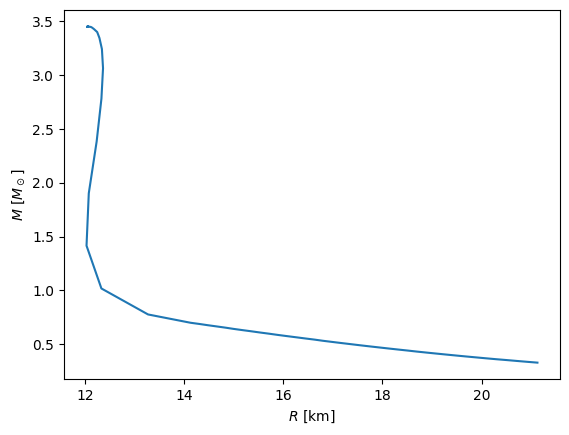

In [21]:
fig, ax = plt.subplots()

ax.plot(radius, mass)
ax.set_xlabel("$R$ [km]")
ax.set_ylabel(r"$M$ [$M_\odot$]")